# Data Processing

## Librairies imports

In [150]:
using Pkg;
Pkg.add("CSV");
Pkg.add("Random");
Pkg.add("DataStructures");
Pkg.add("BenchmarkTools");
Pkg.add("DataFrames");
Pkg.add("Statistics");
Pkg.add("Dates");
Pkg.add("Gadfly");
Pkg.add("MLBase");
Pkg.add("DecisionTree");
Pkg.add("GLM");

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Res

In [151]:
using CSV, DataFrames, GLM, Statistics, Dates, Gadfly, Random, MLBase;
include("utils/precipitation.jl");

## Build features

### 1. Ouvrages_surverse.csv

#### ID_ouvrage, Latitude, Longitude, Height

In [152]:
ouvrages = CSV.read("data/ouvrages-surverses.csv");
colnames = ["N_Env", "ID_SOMA", "ID_OUVRAGE", "NOM", "SOMA_SEC", "REGION", "TP_X", "TP_Y", "TP_Z", "TP_LAT", "TP_LNG", "EMI_X", "EMI_Y", "EMI_LNG", "EMI_LAT"];
names!(ouvrages, Symbol.(colnames));
select!(ouvrages, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z]);

#### Replace missing Z index with mean

In [153]:
ouvrages.TP_Z = coalesce.(ouvrages.TP_Z, mean(ouvrages[completecases(ouvrages), :].TP_Z));
first(shuffleDf(ouvrages), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z
,String,Float64,Float64,Float64
1,3480-02D,45.4986,-73.7908,25.43
2,4600-03D,45.4364,-73.8226,26.42
3,4430-06D,45.4304,-73.6655,23.67
4,4620-02D,45.4154,-73.8878,25.8
5,4620-08D,45.4342,-73.8715,19.3526


#### Visualtion des données chargées

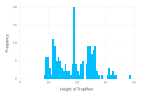

In [154]:
plot(ouvrages, x=:TP_Z, Geom.histogram(bincount=50), Guide.xlabel("Height of TropPlein"),Guide.ylabel("Frequency"))

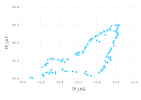

In [155]:
plot(ouvrages,x=:TP_LNG, y=:TP_LAT, Geom.point)

### 2. Surverses.csv

#### NO_ouvrage, Date, Surverse

In [156]:
surverses = CSV.read("data/surverses.csv", missingstring="-99999");

first(shuffleDf(surverses),5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,4330-02D,2015-07-01,1,P
2,3240-02D,2018-08-22,0,missing
3,3480-01D,2014-05-09,0,missing
4,4240-02D,2018-01-18,0,missing
5,3275-02D,2018-02-27,0,missing


#### Filter months

In [157]:
surverses = filter(row -> month(row.DATE) > 4, surverses);
surverses = filter(row -> month(row.DATE) < 11, surverses);

#### Filter non rain surverses

In [158]:
raison = coalesce.(surverses[:,:RAISON],"Inconnue");
surverses[!,:RAISON] = raison;

surverses = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], surverses);
select!(surverses, [:NO_OUVRAGE, :DATE, :SURVERSE]);

#### Remove missing data and rename

In [159]:
surverses = dropmissing(surverses, disallowmissing=true);
rename!(surverses, :NO_OUVRAGE => :ID_OUVRAGE);
first(shuffleDf(surverses), 5)

,ID_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0672-01D,2018-08-07,0
2,3400-01D,2018-05-26,0
3,3350-03D,2013-08-11,0
4,4240-01D,2017-07-01,0
5,4600-01D,2013-08-27,0


### 3. Precipitation.csv

#### Date, Heure, McTavish, Bellevue, Assomption, Trudeau, StHubert

#### Load and filter months between May & October included

In [160]:
precipitations = CSV.read("data/precipitations.csv",missingstring="-99999");
rename!(precipitations, Symbol("St-Hubert")=>:StHubert);

precipitations = filter(row -> month(row.date) > 4, precipitations);
precipitations = filter(row -> month(row.date) < 11, precipitations); 

In [161]:
first(shuffleDf(precipitations),5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-07-25,12,0,0,0,0,missing
2,2019-08-28,22,0,missing,missing,0,0
3,2019-10-27,7,4,missing,missing,6,8
4,2017-09-15,3,missing,0,0,0,0
5,2016-08-25,22,0,0,0,0,0


#### Replace missing data by 0

In [162]:
#OLD WAY

#precipitation[!,:McTavish] = coalesce.(precipitation[:,:McTavish], 0);
#precipitation[!,:Bellevue] = coalesce.(precipitation[:,:Bellevue], 0);
#precipitation[!,:Assomption] = coalesce.(precipitation[:,:Assomption], 0);
#precipitation[!,:Trudeau] = coalesce.(precipitation[:,:Trudeau], 0);
#precipitation[!,:StHubert] = coalesce.(precipitation[:,:StHubert], 0);

#first(shuffleDf(precipitation), 5)

In [163]:
precipitation_by_day = by(precipitations, :date,  
                            McTavish = :McTavish=>mean_wo_missing, 
                            Bellevue = :Bellevue=>mean_wo_missing, 
                            Assomption = :Assomption=>mean_wo_missing,
                            Trudeau = :Trudeau=>mean_wo_missing,
                            StHubert = :StHubert=>mean_wo_missing)

for i=1:size(precipitations,1)
    if isequal(precipitations[i, :McTavish], missing)
        precipitations[i,:McTavish] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:McTavish][1]
    end
    if isequal(precipitations[i, :Bellevue], missing)
        precipitations[i,:Bellevue] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Bellevue][1]
    end
    if isequal(precipitations[i, :Assomption], missing)
        precipitations[i,:Assomption] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Assomption][1]
    end
    if isequal(precipitations[i, :Trudeau], missing)
        precipitations[i,:Trudeau] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Trudeau][1]
    end
    if isequal(precipitations[i, :StHubert], missing)
        precipitations[i,:StHubert] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:StHubert][1]
    end
end

first(shuffleDf(precipitations), 5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-10-15,5,0,0,0,0,0
2,2018-10-01,6,0,0,0,0,0
3,2013-09-03,15,0,0,0,0,0
4,2014-05-31,6,0,0,0,0,0
5,2013-06-06,23,10,10,20,5,0


###  Precipitation aggregation

#### Sum of precipitation for the day

In [164]:
pcp_sum = by(precipitations, :date,  
            McTavish = :McTavish=>sum, 
            Bellevue = :Bellevue=>sum,
            Assomption = :Assomption=>sum, 
            Trudeau = :Trudeau=>sum, 
            StHubert = :StHubert=>sum);
first(shuffleDf(pcp_sum), 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-09-04,0,0,0,0,0
2,2019-08-23,0,0,0,0,0
3,2016-05-05,0,0,0,0,0
4,2017-10-22,0,0,0,0,0
5,2018-06-03,0,21,0,0,0


#### Representation visuelle des données enregistrées des différentes stations. 
(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

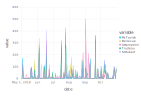

In [165]:
df_for_plot = pcp_sum
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)

plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Maximum precipitation in an hour for the day

In [166]:
pcp_max = by(precipitations, :date,  
            McTavish = :McTavish=>maximum,
            Bellevue = :Bellevue=>maximum, 
            Assomption = :Assomption=>maximum,
            Trudeau = :Trudeau=>maximum,
            StHubert = :StHubert=>maximum)
first(shuffleDf(pcp_max),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2017-10-05,0,0,0,0,2
2,2016-09-23,10,14,10,9,12
3,2017-09-28,0,0,0,0,0
4,2015-05-08,0,0,0,0,0
5,2017-07-14,27,50,0,43,30


#### Representation visuelle des données enregistrées des différentes stations

(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

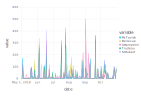

In [167]:
df_for_plot = pcp_max
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Maximum precipitation during three consecutive hours in a day

In [168]:
pcp_max3h = by(precipitations, :date,
                McTavish = :McTavish=>maximum3,
                Bellevue = :Bellevue=>maximum3,
                Assomption = :Assomption=>maximum3,
                Trudeau = :Trudeau=>maximum3,
                StHubert = :StHubert=>maximum3)
first(shuffleDf(pcp_max3h),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2018-10-21,0,0,0,0,0
2,2018-05-16,0,0,0,0,0
3,2016-07-21,0,0,0,0,0
4,2016-10-15,0,0,0,0,0
5,2018-09-06,0,0,9,0,0


#### Representation visuelle des données enregistrées des différentes stations

(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

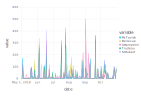

In [169]:
df_for_plot = pcp_max3h
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Visualisation of all three agregations for 1 meteo station

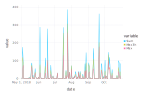

In [170]:
mct_sum = pcp_sum[:,[1,2]]
rename!(mct_sum,:McTavish => :Sum);
mct_sum = filter(row -> year(row.date) == 2018, mct_sum);

mct_max = pcp_max[:,[1,2]]
rename!(mct_max,:McTavish => :Max);
mct_max = filter(row -> year(row.date) == 2018, mct_max);

mct_max3h = pcp_max3h[:,[1,2]]
rename!(mct_max3h,:McTavish => :Max3h);
mct_max3h = filter(row -> year(row.date) == 2018, mct_max3h);

df_for_plot = join(mct_sum, mct_max3h, on = :date);
df_for_plot = join(df_for_plot, mct_max, on = :date);
df_for_plot = melt(df_for_plot, :date)


plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

### Join Dataframes

In [171]:
features = join(ouvrages, surverses, on =:ID_OUVRAGE);
first(shuffleDf(features), 10)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,SURVERSE
,String,Float64,Float64,Float64,Date,Int64
1,4330-02D,45.5387,-73.5394,19.3526,2017-10-22,0
2,4560-02D,45.451,-73.7841,26.18,2015-06-21,0
3,4430-05D,45.424,-73.6573,30.66,2014-09-09,0
4,4260-01D,45.6308,-73.495,12.21,2018-09-14,0
5,3380-01D,45.5533,-73.6703,22.23,2015-05-07,0
6,4620-04D,45.416,-73.8844,25.09,2017-06-10,0
7,3280-02D,45.6137,-73.5995,31.41,2018-10-07,0
8,3490-02D,45.5054,-73.8061,24.49,2016-06-19,0
9,4620-06D,45.4346,-73.8678,32.03,2013-05-27,0


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[172]:2
└ @ Core In[172]:2
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[172]:2
└ @ Core In[172]:2


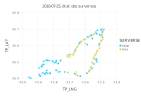

In [172]:
df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:SURVERSE, Guide.title("2018-07-25, état des surverses"))
#first(df_for_geo_plot,5) 

### Add precipitation data to features

#### Get stations lat-lng

In [173]:
station_df = DataFrame(STATION = String[], LAT = Float64[], LNG = Float64[]);

push!(station_df, ["McTavish", 45.504742, -73.579167]);
push!(station_df, ["Bellevue", 45.427222, -73.929167]);
push!(station_df, ["Assomption", 45.809444, -73.434722]);
push!(station_df, ["Trudeau", 45.467778, -73.741667]);
push!(station_df, ["StHubert", 45.5175, -73.416944]);

station_df

,STATION,LAT,LNG
,String,Float64,Float64
1,McTavish,45.5047,-73.5792
2,Bellevue,45.4272,-73.9292
3,Assomption,45.8094,-73.4347
4,Trudeau,45.4678,-73.7417
5,StHubert,45.5175,-73.4169


### Standardize TP and station data

In [174]:
meanlat = mean(features.TP_LAT);
stdlat = std(features.TP_LAT);
features.TP_LAT = (features.TP_LAT .- meanlat) ./ stdlat;
station_df.LAT = (station_df.LAT .- meanlat) ./ stdlat;

meanlng = mean(features.TP_LNG);
stdlng = std(features.TP_LNG);
features.TP_LNG = (features.TP_LNG .- meanlng) ./ stdlng;
station_df.LNG = (station_df.LNG .- meanlng) ./ stdlng;

meanz = mean(features.TP_Z);
stdz = std(features.TP_Z);
features.TP_Z = (features.TP_Z .- meanz) ./ stdz;

In [175]:
station_df

,STATION,LAT,LNG
,String,Float64,Float64
1,McTavish,-0.399934,0.53979
2,Bellevue,-1.29892,-2.14237
3,Assomption,3.13364,1.64672
4,Trudeau,-0.828599,-0.705498
5,StHubert,-0.251981,1.78296


### Augment Features

#### Add pcp_sum, pcp_max, pcp_max3 columns

In [176]:
features.PCP_SUM = zeros(size(features, 1));
features.PCP_MAX = zeros(size(features, 1));
features.PCP_MAX3 = zeros(size(features, 1));
station_ref_df = DataFrame(METEO = fill("", size(features, 1)))
features = hcat(features, station_ref_df)

permutecols!(features, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z, :DATE, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3, :SURVERSE]);
first(features, 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,0642-01D,1.54744,0.945888,-0.0467296,2013-05-01,,0.0,0.0
2,0642-01D,1.54744,0.945888,-0.0467296,2013-05-02,,0.0,0.0
3,0642-01D,1.54744,0.945888,-0.0467296,2013-05-03,,0.0,0.0
4,0642-01D,1.54744,0.945888,-0.0467296,2013-05-04,,0.0,0.0
5,0642-01D,1.54744,0.945888,-0.0467296,2013-05-05,,0.0,0.0


In [177]:
first(shuffleDf(features), 10)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,3500-02D,-0.341412,-1.37645,1.0406,2017-10-28,,0.0,0.0
2,0801-03D,-0.361227,0.937019,-1.18716,2013-07-19,,0.0,0.0
3,4610-08D,-1.30464,-1.56466,-0.0467296,2017-08-19,,0.0,0.0
4,4320-01D,0.111165,0.911256,-0.91946,2016-09-12,,0.0,0.0
5,3560-01D,-0.854953,-1.86736,0.871366,2018-07-30,,0.0,0.0
6,3310-01D,0.865632,0.140067,-0.0117388,2016-08-22,,0.0,0.0
7,4230-06D,1.65681,1.22251,-1.6441,2014-07-02,,0.0,0.0
8,4380-01D,-0.828933,0.658409,-0.0467296,2017-09-27,,0.0,0.0
9,3305-06D,0.86219,0.101591,-1.13947,2017-08-31,,0.0,0.0


#### Find closest station to each ouvrage and add pcp_sum and pcp_max to it

In [178]:
for i=1:size(features, 1)
    id_ouvrage = features[i, 1]; 
    closest_station = "McTavish"; # initial value
    shortest_dist = -1;
    
    # Find closest station
    for j=1:size(station_df, 1)
        dist = findDistance(features[i, :TP_LAT], features[i, :TP_LNG], station_df[j, :LAT], station_df[j, :LNG]);
        
        if shortest_dist == -1 || dist < shortest_dist
            shortest_dist = dist;
            closest_station = station_df[j, :STATION];
        end
    end
    
    # Augment comb with a weighted p_sum, based on the distance to the station
    p_sum = pcp_sum[∈([features[i, :DATE]]).(pcp_sum.date), Symbol(closest_station)];
#     comb[i, :PCP_SUM] = p_sum[1] * (1 - shortest_dist);
    features[i, :PCP_SUM] = p_sum[1]; 
    
    # Augment comb with a weighted p_max, based on the distance to the station
    p_max = pcp_max[∈([features[i, :DATE]]).(pcp_max.date), Symbol(closest_station)]
#     comb[i, :PCP_MAX] = p_max[1] * (1 - shortest_dist);
    features[i, :PCP_MAX] = p_max[1];
    
    # Augment comb with a weighted p_max3h, based on the distance to the station
    p_max3 = pcp_max3h[∈([features[i, :DATE]]).(pcp_max3h.date), Symbol(closest_station)]
#     comb[i, :PCP_MAX3] = p_max3[1] * (1 - shortest_dist);
    features[i, :PCP_MAX3] = p_max3[1]; 
    
    features[i, :METEO] = closest_station
end

#### Remove outlier in PCP_SUM and PCP_MAX AND PCP_MAX3 that cause compression

In [179]:
features[features[:PCP_SUM] .> 750, :PCP_SUM] = 750;
features[features[:PCP_MAX] .> 500, :PCP_MAX] = 500;
features[features[:PCP_MAX3] .> 750, :PCP_MAX3] = 750;

# first(shuffleDf(filter(row -> row.SURVERSE == 1, features)), 5)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[179]:1
└ @ Core In[179]:1
┌ Warning: implicit broadcasting in setindex! is deprecated; use `df[row_inds, col_ind] .= Ref(v)` broadcasting assignment to change the column in place
│   caller = setindex!(::DataFrame, ::Int64, ::BitArray{1}, ::Symbol) at deprecated.jl:1490
└ @ DataFrames /home/maxg/.julia/packages/DataFrames/XuYBH/src/deprecated.jl:1490
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[179]:2
└ @ Core In[179]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[179]:3
└ @ Core In[179]:3


#### TP location colored by their affiliation to its closest meteo station

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[180]:2
└ @ Core In[180]:2
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[180]:2
└ @ Core In[180]:2


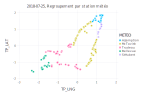

In [180]:
df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:METEO, Guide.title("2018-07-25, Regroupement par station météo"))
#first(df_for_geo_plot,5) 

#### Ouvrage 3350-07D for 2018, when it overflow and quantity based on max3h rain fallen.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[181]:12
└ @ Core In[181]:12
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[181]:12
└ @ Core In[181]:12


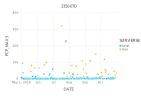

In [181]:

# 3260-01D dans Rivière-des-Prairies
# 3350-07D dans Ahunstic
# 4240-01D dans Pointe-aux-Trembles
# 4350-01D dans le Vieux-Montréal
# 4380-01D dans Verdun

id_ouvrage_to_show = "3350-07D"
df_temp = filter(row -> row.ID_OUVRAGE ∈ [id_ouvrage_to_show], features)
df_temp = filter(row -> year(row.DATE) == 2018, df_temp);
df_temp = df_temp[!,[:ID_OUVRAGE, :DATE, :PCP_MAX3, :SURVERSE]]
df_temp[:SURVERSE] = convert(Array{Bool,1}, df_temp[:SURVERSE])



plot(df_temp, x=:DATE, y=:PCP_MAX3, Geom.point, color=:SURVERSE,Guide.title(id_ouvrage_to_show))
#first(shuffleDf(df_temp), 10)

### Split dates into months and days

In [183]:
features.MONTH = month.(features.DATE);
features.DAY = day.(features.DATE);
first(shuffleDf(features[!, [:DATE, :MONTH, :DAY]]), 5)

,DATE,MONTH,DAY
,Date,Int64,Int64
1,2017-06-04,6,4
2,2013-07-03,7,3
3,2013-05-01,5,1
4,2016-10-15,10,15
5,2013-06-20,6,20


## Split Dataframes into train, validation and test

In [218]:
function partitionTrainTest(data, at = 0.8) # https://discourse.julialang.org/t/simple-tool-for-train-test-split/473/2
    n = nrow(data)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return data[train_idx,:], data[test_idx,:]
end


partitionTrainTest (generic function with 2 methods)

In [219]:
function standarizeTrainTestCol(X_train, X_test, col)
    mean_train_col = mean(X_train[!, col]);
    std_train_col = std(X_train[!, col]);
    X_train[!, col] = (X_train[!, col] .- mean_train_col) ./ std_train_col;
    X_test[!, col] = (X_test[!, col] .- mean_train_col) ./ std_train_col;
    return X_train, X_test
end
    

standarizeTrainTestCol (generic function with 3 methods)

####  Standardize the PCP and Date before splitting into X_train and X_val

In [220]:
X_train = filter(row-> year(row.DATE) .< 2019, features)
 

#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_SUM)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX3)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :MONTH)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :DAY)

X_train, X_val = partitionTrainTest(X_train, 0.8)

first(shuffleDf(X_train),5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,3350-02D,0.453235,-0.0681191,-0.0467296,2015-06-14,McTavish,-0.400418,-0.401707
2,4265-01D,1.00593,1.15342,-1.21178,2013-05-24,StHubert,-0.400418,-0.401707
3,3310-01D,0.865632,0.140067,-0.0117388,2017-10-30,McTavish,0.196801,0.213567
4,4770-01D,1.37098,1.22166,-1.36717,2014-09-25,StHubert,-0.400418,-0.401707
5,3390-01D,0.131398,-0.169766,0.342119,2018-09-09,McTavish,-0.400418,-0.401707


In [221]:
first(shuffleDf(X_test),5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX,PCP_MAX3
,String,Float64,Float64,Float64,Date,String,Float64,Float64,Float64


In [222]:
first(shuffleDf(X_val),5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,4620-03D,-1.36501,-1.84586,2.10064,2018-05-20,Bellevue,0.834739,1.78252
2,4610-06D,-1.26037,-1.58426,1.44523,2018-05-21,Bellevue,-0.400418,-0.401707
3,3350-04D,0.427831,-0.081799,-1.57333,2018-07-16,McTavish,-0.400418,-0.401707
4,0801-01D,-0.234605,0.936104,-0.914844,2018-06-01,McTavish,-0.291832,-0.155598
5,3280-01D,1.09943,0.334804,0.646744,2014-10-20,McTavish,-0.346125,-0.278652


###  Standardize the PCP and Date

In [ ]:
# mean_pcpsum = mean(features.PCP_SUM);
# std_pcpsum = std(features.PCP_SUM);
# features.PCP_SUM = (features.PCP_SUM .- mean_pcpsum) ./ std_pcpsum;

# mean_pcpmax = mean(features.PCP_MAX);
# std_pcpmax = std(features.PCP_MAX);
# features.PCP_MAX = (features.PCP_MAX .- mean_pcpmax) ./ std_pcpmax;

# mean_pcpmax3 = mean(features.PCP_MAX3);
# std_pcpmax3 = std(features.PCP_MAX3);
# features.PCP_MAX3 = (features.PCP_MAX3 .- mean_pcpmax3) ./ std_pcpmax3;

# meanmonth = mean(features.MONTH);
# stdmonth = std(features.MONTH);
# features.MONTH = (features.MONTH .- meanmonth) ./ stdmonth;

# meanday = mean(features.DAY);
# stdday = std(features.DAY);
# features.DAY = (features.DAY .- meanday) ./ stdday;

In [ ]:
first(shuffleDf(filter(row -> row.SURVERSE == 1, features)), 5)